Final Project


Name : Yu-Shuo Chen

Github Username : cys9689

USC ID :6115294340

In [5]:
import logging
import os
import os.path as op
from pathlib import Path
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Problem 1.a & b Identify the problem and Data Preprocessing

the data preprocessing code is provided by the project itself without any modification from student

In [6]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [7]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [8]:
def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        
        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([]) 

    return X, y

In [9]:
import random
import tensorflow as tf
from PIL import Image 
"""
def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        
        img = Image.open(img_loc_str).convert('RGB')
        
        
        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    return X, y
"""
def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

### First CNN Archetectural (Model 1 ) - with relative complex model of more neuron in seconds and thir layers

Epoch 1/20


2023-12-10 17:51:46.057627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


928/928 [==============================] - 895s 962ms/step - loss: 3.4953 - accuracy: 0.7511 - val_loss: 0.7185 - val_accuracy: 0.8479 - lr: 0.0010
Epoch 2/20
928/928 [==============================] - 879s 947ms/step - loss: 0.8842 - accuracy: 0.8085 - val_loss: 0.8992 - val_accuracy: 0.8582 - lr: 0.0010
Epoch 3/20
928/928 [==============================] - 881s 948ms/step - loss: 1.1140 - accuracy: 0.8579 - val_loss: 1.1831 - val_accuracy: 0.8639 - lr: 0.0010
Epoch 4/20
928/928 [==============================] - 894s 962ms/step - loss: 1.2661 - accuracy: 0.8804 - val_loss: 2.2374 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 5/20
928/928 [==============================] - 913s 983ms/step - loss: 0.5370 - accuracy: 0.9252 - val_loss: 0.9271 - val_accuracy: 0.7919 - lr: 2.0000e-04
Epoch 6/20
928/928 [==============================] - 914s 984ms/step - loss: 0.5735 - accuracy: 0.9310 - val_loss: 0.8608 - val_accuracy: 0.8229 - lr: 2.0000e-04


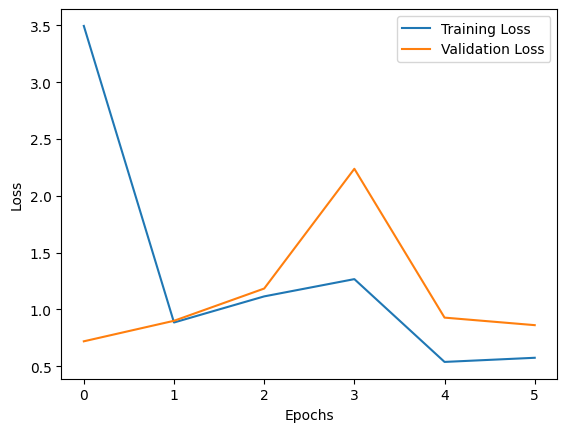

In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(299, 299, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Flatten the output for Dense layer
model.add(layers.Flatten())

model.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=Adam(clipvalue=0.5, learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, batch_size=32, callbacks=[early_stopping, lr_scheduler])


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
test_loss, test_accuracy = model.evaluate(tf_dataset_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


928/928 [==============================] - 129s 138ms/step - loss: 1.0794 - accuracy: 0.5062
Test Loss: 1.0794131755828857
Test Accuracy: 0.5062165260314941


In [19]:
from sklearn.metrics import classification_report

print("-----Training Dataset Classification Report-----")
y_pred_train_probs = model.predict(tf_dataset_train)
y_pred_train_lables = np.argmax(y_pred_train_probs,axis =1)
y_true = np.concatenate([y.numpy() for x, y in tf_dataset_train])
report = classification_report(y_true,y_pred_train_lables)
print(report)

print("-----Validation Dataset Classification Report-----")
y_pred_val_probs = model.predict(tf_dataset_val)
y_pred_val_lables = np.argmax(y_pred_val_probs,axis =1)
y_true = np.concatenate([y.numpy() for x, y in tf_dataset_val])
report = classification_report(y_true,y_pred_val_lables)
print(report)



-----Training Dataset Classification Report-----
928/928 [==============================] - 124s 133ms/step
              precision    recall  f1-score   support

           0       0.41      0.91      0.57     12235
           1       0.60      0.10      0.17     17444

    accuracy                           0.43     29679
   macro avg       0.51      0.50      0.37     29679
weighted avg       0.52      0.43      0.33     29679

-----Validation Dataset Classification Report-----
353/353 [==============================] - 47s 134ms/step
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      7654
           1       0.32      0.18      0.23      3632

    accuracy                           0.61     11286
   macro avg       0.50      0.50      0.49     11286
weighted avg       0.56      0.61      0.58     11286



In [20]:

print("-----Tesing Dataset Classification Report-----")
y_pred_probs = model.predict(tf_dataset_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y.numpy() for x, y in tf_dataset_test])

report = classification_report(y_true, y_pred_labels)

print(report)


-----Tesing Dataset Classification Report-----
928/928 [==============================] - 123s 132ms/step
              precision    recall  f1-score   support

           0       0.41      0.91      0.57     12235
           1       0.59      0.09      0.16     17444

    accuracy                           0.43     29679
   macro avg       0.50      0.50      0.36     29679
weighted avg       0.52      0.43      0.33     29679



### Explaination for model 1

The CNN described above is the initial network run without any training data augmentation. Everything else remains consistent with the problem descriptions. 

However, the validation loss does not exhibit improvement with increasing epoch numbers. Consequently, early stopping is triggered, and the epochs stop at epoch 6 with 

the best accuracy recorded at 0.9310 for the validation set. Unfortunately, this did not translate to a satisfactory performance on the test set, indicating potential overfitting to the training and validation data.

The next step involves optimizing the model by reducing the number of neurons in each layer. Notably, the training and validation errors show a decreasing trend as the epochs increase.

Examining the results for training, validation, and testing, it is observed that the recall for classifying the background is high, but not as effective for classifying frost images. 

This suggests that the true positive or false negative rates for frost images are relatively low. The next step will involve addressing overfitting to assess potential improvements.

### Second CNN Archetectural (Model 2) - with relative simple model by less neuron

Epoch 1/20
928/928 [==============================] - 327s 350ms/step - loss: 0.9923 - accuracy: 0.7113 - val_loss: 0.7664 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 2/20
928/928 [==============================] - 323s 348ms/step - loss: 0.7717 - accuracy: 0.7672 - val_loss: 0.6333 - val_accuracy: 0.8286 - lr: 0.0010
Epoch 3/20
928/928 [==============================] - 323s 348ms/step - loss: 0.9288 - accuracy: 0.8110 - val_loss: 0.8449 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 4/20
928/928 [==============================] - 320s 345ms/step - loss: 1.0729 - accuracy: 0.8282 - val_loss: 1.4051 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 5/20
928/928 [==============================] - 323s 348ms/step - loss: 1.1483 - accuracy: 0.8416 - val_loss: 1.1694 - val_accuracy: 0.7046 - lr: 0.0010
Epoch 6/20
928/928 [==============================] - 327s 352ms/step - loss: 1.4134 - accuracy: 0.8598 - val_loss: 1.6632 - val_accuracy: 0.9256 - lr: 0.0010
Epoch 7/20
928/928 [==========================

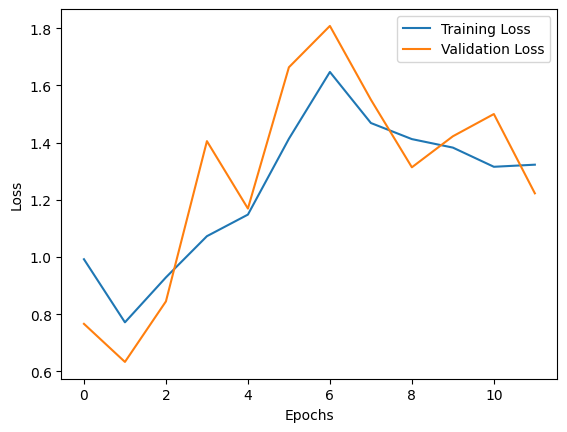

In [24]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(299, 299, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=Adam(clipvalue=0.5, learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-1)

history = model.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, batch_size=32, callbacks=[early_stopping, lr_scheduler])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
test_loss, test_accuracy = model.evaluate(tf_dataset_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


928/928 [==============================] - 129s 139ms/step - loss: 0.7715 - accuracy: 0.7779
Test Loss: 0.7715285420417786
Test Accuracy: 0.7779237627983093


### Explaination for model 2

The CNN described above is the second network run without any training data augmentation. Everything else remains consistent with the problem descriptions.

It appears that we have addressed the overfitting issue compared to the first model. However, a new issue has arisen where the training loss and validation 

loss do not converge as the epochs increase, indicating that the model is still suffering from overfitting. Despite the model having a relatively simple structure

 and a low learning rate, we have decided to address this by increasing the amount of data through the implementation of data augmentation. This adjustment aims to 
 
 improve the model's ability to generalize and reduce overfitting tendencies. We will monitor the results to assess the impact of data augmentation on the model's performance.

### Third CNN Archetectural (Model 3) - with relative simple model by less neuron w/ data augmentation

In [10]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2


def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.adjust_contrast(image, tf.random.uniform([], 0.5, 1.5))

    return image, label


tf_dataset_train_augmented = tf_dataset_train.map(augment_image)


Epoch 1/20
928/928 [==============================] - 252s 270ms/step - loss: 1.2463 - accuracy: 0.7040 - val_loss: 0.6892 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 2/20
928/928 [==============================] - 249s 268ms/step - loss: 0.8483 - accuracy: 0.7147 - val_loss: 0.5595 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 3/20
928/928 [==============================] - 251s 270ms/step - loss: 0.7584 - accuracy: 0.7483 - val_loss: 0.6917 - val_accuracy: 0.7702 - lr: 0.0010
Epoch 4/20
928/928 [==============================] - 248s 267ms/step - loss: 0.7904 - accuracy: 0.7644 - val_loss: 0.5367 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 5/20
928/928 [==============================] - 253s 273ms/step - loss: 0.8530 - accuracy: 0.7790 - val_loss: 0.8863 - val_accuracy: 0.8834 - lr: 0.0010
Epoch 6/20
928/928 [==============================] - 249s 269ms/step - loss: 0.9068 - accuracy: 0.7853 - val_loss: 1.6274 - val_accuracy: 0.8446 - lr: 0.0010
Epoch 7/20
928/928 [==========================

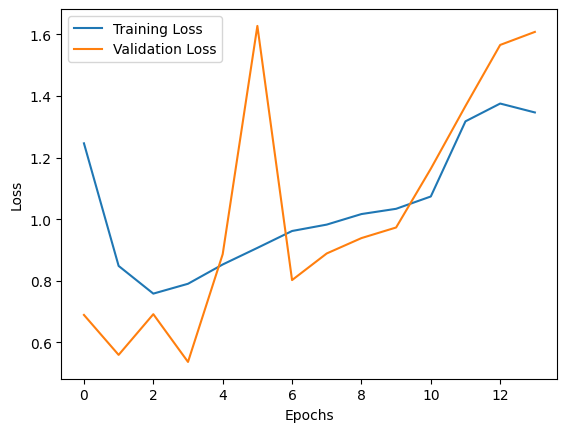

In [15]:
model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(299, 299, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Dense(2, activation='softmax'))


model.compile(optimizer=Adam(clipvalue=0.5, learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-1)

history = model.fit(tf_dataset_train_augmented, epochs=20, validation_data=tf_dataset_val, batch_size=32, callbacks=[early_stopping, lr_scheduler])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(tf_dataset_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

928/928 [==============================] - 131s 141ms/step - loss: 1.1393 - accuracy: 0.8248
Test Loss: 1.139286994934082
Test Accuracy: 0.824825644493103


In [ ]:
from sklearn.metrics import classification_report

print("-----Training Dataset Classification Report-----")
y_pred_train_probs = model.predict(tf_dataset_train_augmented)
y_pred_train_lables = np.argmax(y_pred_train_probs,axis =1)
y_true = np.concatenate([y.numpy() for x, y in tf_dataset_train_augmented])
report = classification_report(y_true,y_pred_train_lables)
print(report)

print("-----Validation Dataset Classification Report-----")
y_pred_val_probs = model.predict(tf_dataset_val)
y_pred_val_lables = np.argmax(y_pred_val_probs,axis =1)
y_true = np.concatenate([y.numpy() for x, y in tf_dataset_val])
report = classification_report(y_true,y_pred_val_lables)
print(report)


print("-----Tesing Dataset Classification Report-----")
y_pred_probs = model.predict(tf_dataset_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y.numpy() for x, y in tf_dataset_test])

report = classification_report(y_true, y_pred_labels)

print(report)


-----Training Dataset Classification Report-----
928/928 [==============================] - 123s 132ms/step
              precision    recall  f1-score   support

           0       0.41      0.52      0.46     12235
           1       0.59      0.48      0.53     17444

    accuracy                           0.50     29679
   macro avg       0.50      0.50      0.50     29679
weighted avg       0.52      0.50      0.50     29679

-----Validation Dataset Classification Report-----
353/353 [==============================] - 46s 131ms/step
              precision    recall  f1-score   support

           0       0.68      0.61      0.64      7654
           1       0.33      0.41      0.37      3632

    accuracy                           0.54     11286
   macro avg       0.51      0.51      0.51     11286
weighted avg       0.57      0.54      0.55     11286

-----Tesing Dataset Classification Report-----
928/928 [==============================] - 122s 132ms/step
              precision

### Explaination for model3


The CNN described above is the third network run without some training data augmentation. Everything else remains consistent with the problem descriptions.

The data augmentation implemented here includes image flipping and contrast adjustment. These methods were selected because frost detection can be more effective

 under varying contrast conditions (https://dataverse.jpl.nasa.gov/file.xhtml?fileId=83038&version=4.0).

The results indicate an improvement in test accuracy. However, it's noteworthy that the minimum validation loss and training loss occur at epoch 3 and increase afterward.

When examining precision, recall, and F1-score, there is a slightly more balanced performance between background and frost results compared to the first model. Although there

 is room for improvement, the frost images exhibit slightly better precision, recall, and F1-score.

The next step involves considering an increase in the number of neurons for the CNN architecture to explore the potential for a better classifier. This adjustment aims to further

 enhance the model's discriminatory capabilities and improve overall performance

Epoch 1/20


2023-12-11 14:08:09.522988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


928/928 [==============================] - 891s 958ms/step - loss: 3.7610 - accuracy: 0.6894 - val_loss: 0.9982 - val_accuracy: 0.8573 - lr: 0.0010
Epoch 2/20
928/928 [==============================] - 894s 962ms/step - loss: 0.9515 - accuracy: 0.7497 - val_loss: 0.9627 - val_accuracy: 0.7613 - lr: 0.0010
Epoch 3/20
928/928 [==============================] - 910s 980ms/step - loss: 1.4042 - accuracy: 0.7852 - val_loss: 1.9252 - val_accuracy: 0.6822 - lr: 0.0010
Epoch 4/20
928/928 [==============================] - 931s 1s/step - loss: 2.4293 - accuracy: 0.8337 - val_loss: 2.2631 - val_accuracy: 0.8093 - lr: 0.0010
Epoch 5/20
928/928 [==============================] - 930s 1s/step - loss: 2.9523 - accuracy: 0.8592 - val_loss: 2.7535 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 6/20
928/928 [==============================] - 970s 1s/step - loss: 1.1907 - accuracy: 0.9131 - val_loss: 0.9375 - val_accuracy: 0.9688 - lr: 2.0000e-04
Epoch 7/20
928/928 [==============================] - 972s 1s/

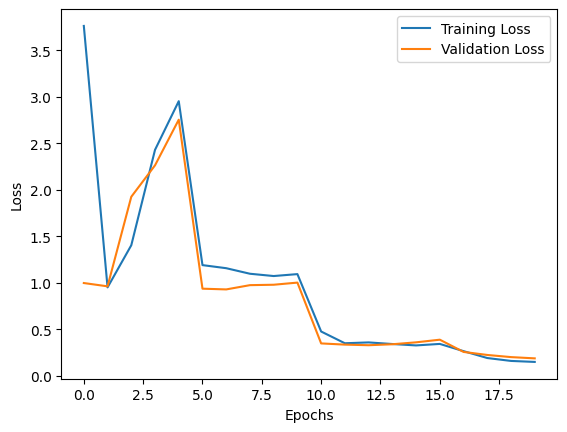

In [11]:

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define the model
model = models.Sequential()

# First Convolutional Layer
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(299, 299, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Convolutional Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Flatten the output for Dense layer
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(layers.Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(clipvalue=0.5, learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(tf_dataset_train_augmented, epochs=20, validation_data=tf_dataset_val, batch_size=32, callbacks=[early_stopping, lr_scheduler])

# Plot training and validation errors vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
test_loss, test_accuracy = model.evaluate(tf_dataset_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

from sklearn.metrics import classification_report

print("-----Training Dataset Classification Report-----")
y_pred_train_probs = model.predict(tf_dataset_train_augmented)
y_pred_train_lables = np.argmax(y_pred_train_probs,axis =1)
y_true = np.concatenate([y.numpy() for x, y in tf_dataset_train_augmented])
report = classification_report(y_true,y_pred_train_lables)
print(report)

print("-----Validation Dataset Classification Report-----")
y_pred_val_probs = model.predict(tf_dataset_val)
y_pred_val_lables = np.argmax(y_pred_val_probs,axis =1)
y_true = np.concatenate([y.numpy() for x, y in tf_dataset_val])
report = classification_report(y_true,y_pred_val_lables)
print(report)


print("-----Tesing Dataset Classification Report-----")
y_pred_probs = model.predict(tf_dataset_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y.numpy() for x, y in tf_dataset_test])

report = classification_report(y_true, y_pred_labels)

print(report)

928/928 [==============================] - 216s 231ms/step - loss: 0.1816 - accuracy: 0.9620
Test Loss: 0.18155045807361603
Test Accuracy: 0.9619933366775513
-----Training Dataset Classification Report-----
928/928 [==============================] - 224s 241ms/step
              precision    recall  f1-score   support

           0       0.42      0.49      0.45     12235
           1       0.59      0.51      0.55     17444

    accuracy                           0.50     29679
   macro avg       0.50      0.50      0.50     29679
weighted avg       0.52      0.50      0.51     29679

-----Validation Dataset Classification Report-----
353/353 [==============================] - 81s 227ms/step
              precision    recall  f1-score   support

           0       0.68      0.71      0.70      7654
           1       0.33      0.31      0.32      3632

    accuracy                           0.58     11286
   macro avg       0.51      0.51      0.51     11286
weighted avg       0.57   

### Data Augmentation Applied w/ more neuron for each layer

### Tansfer Learning 
#### ImageNet

In [8]:
batch_size = 8
tf_dataset_train_ = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train_ = tf_dataset_train_.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train_ = tf_dataset_train_.shuffle(buffer_size=buffer_size).batch(batch_size) 


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.adjust_contrast(image, tf.random.uniform([], 0.5, 1.5))
    return image, label

tf_dataset_train_augmented = tf_dataset_train_.map(augment_image)

base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in base_model_efficientnet.layers[:-2]:
    layer.trainable = False

model_efficientnet = models.Sequential([
    base_model_efficientnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid') 

model_efficientnet.compile(optimizer=Adam(clipvalue=0.5, learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history_efficientnet = model_efficientnet.fit(
    tf_dataset_train_augmented,
    epochs=15,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping]
)



Epoch 1/15
3710/3710 [==============================] - 365s 97ms/step - loss: 0.7176 - accuracy: 0.5783 - val_loss: 0.7358 - val_accuracy: 0.3218
Epoch 2/15
3710/3710 [==============================] - 362s 98ms/step - loss: 0.6810 - accuracy: 0.5869 - val_loss: 0.7197 - val_accuracy: 0.3218
Epoch 3/15
3710/3710 [==============================] - 356s 96ms/step - loss: 0.6796 - accuracy: 0.5878 - val_loss: 0.7812 - val_accuracy: 0.3218
Epoch 4/15
3710/3710 [==============================] - 353s 95ms/step - loss: 0.6786 - accuracy: 0.5878 - val_loss: 0.8184 - val_accuracy: 0.3218
Epoch 5/15
3710/3710 [==============================] - 351s 94ms/step - loss: 0.6793 - accuracy: 0.5878 - val_loss: 0.7376 - val_accuracy: 0.3218
Epoch 6/15
3710/3710 [==============================] - 349s 94ms/step - loss: 0.6787 - accuracy: 0.5878 - val_loss: 0.8177 - val_accuracy: 0.3218
Epoch 7/15
3710/3710 [==============================] - 356s 96ms/step - loss: 0.6784 - accuracy: 0.5877 - val_loss: 0

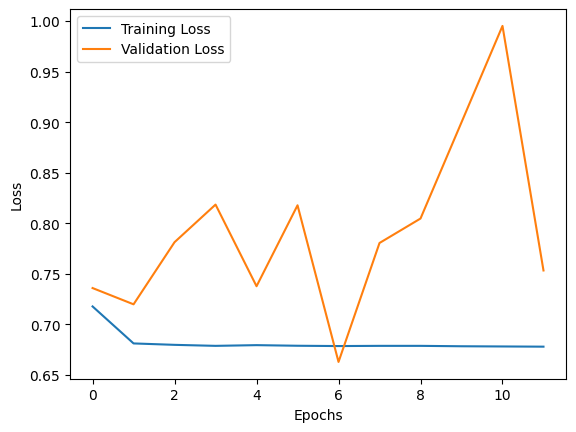

In [22]:
# due to lost of work, we manually type in the loss value from above to avoid re-run work for the model
train_loss = [0.7176,0.6810,0.6796,0.6786,0.6793,0.6787,0.6784,0.6786,0.6786,0.6782,0.678,0.6778]
val_loss   = [0.7358,0.7197,0.7812,0.8184,0.7376,0.8177,0.6627,0.7804,0.8046,0.8998,0.9952,0.7532]
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss , label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
test_loss, test_accuracy = model_efficientnet.evaluate(tf_dataset_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


print("-----Training Dataset Classification Report-----")
y_pred_train_probs = model_efficientnet.predict(tf_dataset_train_augmented)
y_pred_train_lables = np.argmax(y_pred_train_probs,axis =1)
y_true = np.concatenate([y.numpy() for x, y in tf_dataset_train_augmented])
report = classification_report(y_true,y_pred_train_lables)
print(report)

print("-----Validation Dataset Classification Report-----")
y_pred_val_probs = model_efficientnet.predict(tf_dataset_val)
y_pred_val_lables = np.argmax(y_pred_val_probs,axis =1)
y_true = np.concatenate([y.numpy() for x, y in tf_dataset_val])
report = classification_report(y_true,y_pred_val_lables)
print(report)


print("-----Tesing Dataset Classification Report-----")
y_pred_probs = model_efficientnet.predict(tf_dataset_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y.numpy() for x, y in tf_dataset_test])

report = classification_report(y_true, y_pred_labels)

print(report)

928/928 [==============================] - 189s 203ms/step - loss: 0.7132 - accuracy: 0.4122
Test Loss: 0.7131993770599365
Test Accuracy: 0.41224434971809387
-----Training Dataset Classification Report-----
3710/3710 [==============================] - 210s 56ms/step


/Users/nickk/tensorflow-test/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nickk/tensorflow-test/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nickk/tensorflow-test/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

           0       0.41      1.00      0.58     12235
           1       0.00      0.00      0.00     17444

    accuracy                           0.41     29679
   macro avg       0.21      0.50      0.29     29679
weighted avg       0.17      0.41      0.24     29679

-----Validation Dataset Classification Report-----
353/353 [==============================] - 73s 201ms/step


/Users/nickk/tensorflow-test/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nickk/tensorflow-test/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nickk/tensorflow-test/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

           0       0.68      1.00      0.81      7654
           1       0.00      0.00      0.00      3632

    accuracy                           0.68     11286
   macro avg       0.34      0.50      0.40     11286
weighted avg       0.46      0.68      0.55     11286

-----Tesing Dataset Classification Report-----
928/928 [==============================] - 186s 200ms/step
              precision    recall  f1-score   support

           0       0.41      1.00      0.58     12235
           1       0.00      0.00      0.00     17444

    accuracy                           0.41     29679
   macro avg       0.21      0.50      0.29     29679
weighted avg       0.17      0.41      0.24     29679



/Users/nickk/tensorflow-test/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nickk/tensorflow-test/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nickk/tensorflow-test/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### Comparison Between Transfer Learning (Image Net) with CNN+MLP
Compares Image Net model performance with the CNN+MLP model we train earlier. the Image Net perform poorly. This might due to our dataset is really a rare category image in comparison 

to all the image that included in the pre-trained model of Image Net.And lead to a suboptimal region in prediction. The neuron for the dense layer has been increase from 8 to 64. The model still

behave with a low accuracy in validation set and test set. Meanwhle during the training phase, the valdiation loss failed to converge to minimum points

#### ResNet50

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers up to the penultimate layer
for layer in base_model_resnet50.layers[:-2]:
    layer.trainable = False

model_resnet50 = models.Sequential([
    base_model_resnet50,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  # Adjust dropout rate as needed
    layers.Dense(2, activation='softmax')  # Use 'softmax' for binary classification
    
])

model_resnet50.compile(optimizer=Adam(clipvalue=0.5, learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_resnet50 = model_resnet50.fit(tf_dataset_train_augmented, epochs=15,validation_data=tf_dataset_val,callbacks=[early_stopping, lr_scheduler])

Epoch 1/15
3710/3710 [==============================] - 407s 109ms/step - loss: 0.5920 - accuracy: 0.7241 - val_loss: 1.2371 - val_accuracy: 0.3459 - lr: 0.0010
Epoch 2/15
3710/3710 [==============================] - 397s 107ms/step - loss: 0.5582 - accuracy: 0.7322 - val_loss: 0.8359 - val_accuracy: 0.4610 - lr: 0.0010
Epoch 3/15
3710/3710 [==============================] - 398s 107ms/step - loss: 0.5506 - accuracy: 0.7327 - val_loss: 2.7999 - val_accuracy: 0.3220 - lr: 0.0010
Epoch 4/15
3710/3710 [==============================] - 401s 108ms/step - loss: 0.5535 - accuracy: 0.7355 - val_loss: 0.4420 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 5/15
3710/3710 [==============================] - 400s 108ms/step - loss: 0.5532 - accuracy: 0.7374 - val_loss: 68.4098 - val_accuracy: 0.3218 - lr: 0.0010
Epoch 6/15
3710/3710 [==============================] - 398s 107ms/step - loss: 0.5665 - accuracy: 0.7210 - val_loss: 3.9080 - val_accuracy: 0.3218 - lr: 0.0010
Epoch 7/15
3710/3710 [===========

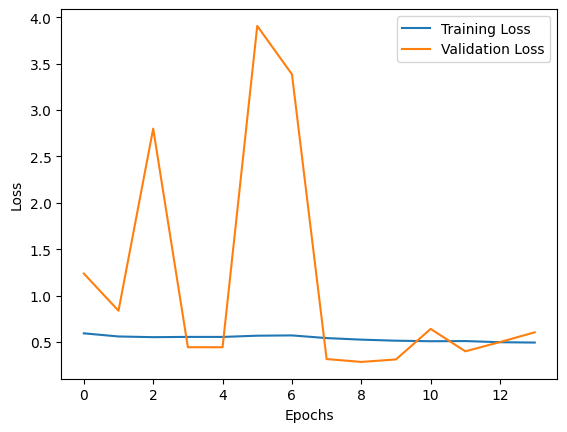

In [25]:
# due to lost of work, we manually type in the loss value from above to avoid re-run work for the model
train_loss = [0.5920,0.5582,0.5506,0.5535,0.5532,0.5665,0.5695,0.5407,0.5239,0.5125,0.5068,0.5086,0.4961,0.4925]
val_loss   = [1.2371,0.8359,2.7999,0.4420,0.4420,3.9080,3.3866,0.3144,0.2836,0.3105,0.6398,0.3979,0.4980,0.6028]
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss , label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
test_loss, test_accuracy =  model_resnet50.evaluate(tf_dataset_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


print("-----Training Dataset Classification Report-----")
y_pred_train_probs =  model_resnet50.predict(tf_dataset_train_augmented)
y_pred_train_lables = np.argmax(y_pred_train_probs,axis =1)
y_true = np.concatenate([y.numpy() for x, y in tf_dataset_train_augmented])
report = classification_report(y_true,y_pred_train_lables)
print(report)

print("-----Validation Dataset Classification Report-----")
y_pred_val_probs =  model_resnet50.predict(tf_dataset_val)
y_pred_val_lables = np.argmax(y_pred_val_probs,axis =1)
y_true = np.concatenate([y.numpy() for x, y in tf_dataset_val])
report = classification_report(y_true,y_pred_val_lables)
print(report)


print("-----Tesing Dataset Classification Report-----")
y_pred_probs =  model_resnet50.predict(tf_dataset_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y.numpy() for x, y in tf_dataset_test])

report = classification_report(y_true, y_pred_labels)

print(report)

928/928 [==============================] - 713s 768ms/step - loss: 0.8064 - accuracy: 0.5268
Test Loss: 0.806357204914093
Test Accuracy: 0.5268034934997559
-----Training Dataset Classification Report-----
3710/3710 [==============================] - 784s 211ms/step
              precision    recall  f1-score   support

           0       0.41      0.88      0.56     12235
           1       0.59      0.13      0.21     17444

    accuracy                           0.44     29679
   macro avg       0.50      0.50      0.38     29679
weighted avg       0.52      0.44      0.35     29679

-----Validation Dataset Classification Report-----
353/353 [==============================] - 267s 752ms/step
              precision    recall  f1-score   support

           0       0.68      0.78      0.73      7654
           1       0.33      0.23      0.27      3632

    accuracy                           0.60     11286
   macro avg       0.50      0.50      0.50     11286
weighted avg       0.57  

### model evaluation on ResNet50 in JPL Dataset


Base on the result from the ResNet50, we can see the test accuracy is around 0.52 which is relative low compares to all the CNN network we trained ealier.

The training loss did converge as epoches increase. and the classification reports shows a poort prediction with frost image. However, this model still 

perform better than the ImageNet model. The fact that ResNet 50 cannot provide a good result might due to a rare category image

### VGG16

In [18]:
from tensorflow.keras.applications import VGG16


base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in base_model_vgg16.layers[:-2]:
    layer.trainable = False

model_vgg16 = models.Sequential([
    base_model_vgg16,
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3), 
    layers.Dense(2, activation='softmax') 
])

model_vgg16.compile(optimizer=Adam(clipvalue=0.5, learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_vgg16 = model_vgg16.fit(tf_dataset_train_augmented,epochs=15,validation_data=tf_dataset_val,callbacks=[early_stopping, lr_scheduler])

Epoch 1/15
3710/3710 [==============================] - 2229s 600ms/step - loss: 0.5014 - accuracy: 0.8286 - val_loss: 0.6939 - val_accuracy: 0.7371 - lr: 0.0010
Epoch 2/15
3710/3710 [==============================] - 1581s 426ms/step - loss: 0.3842 - accuracy: 0.8547 - val_loss: 0.3930 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 3/15
3710/3710 [==============================] - 1902s 513ms/step - loss: 0.3500 - accuracy: 0.8705 - val_loss: 0.3866 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 4/15
3710/3710 [==============================] - 614s 165ms/step - loss: 0.3448 - accuracy: 0.8687 - val_loss: 0.2572 - val_accuracy: 0.9024 - lr: 0.0010
Epoch 5/15
3710/3710 [==============================] - 614s 165ms/step - loss: 0.3559 - accuracy: 0.8563 - val_loss: 0.2813 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 6/15
3710/3710 [==============================] - 625s 168ms/step - loss: 0.3652 - accuracy: 0.8502 - val_loss: 0.7905 - val_accuracy: 0.6011 - lr: 0.0010
Epoch 7/15
3710/3710 [=========

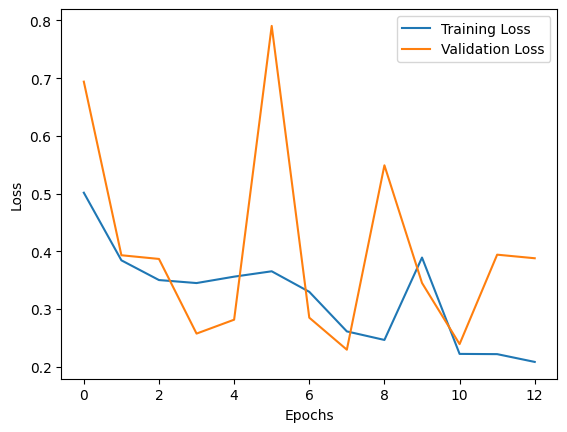

In [24]:
# due to lost of work, we manually type in the loss value from above to avoid re-run work for the model
train_loss = [0.5014,0.3842,0.3500,0.3448,0.3559,0.3652,0.3296,0.2610,0.2462,0.389,0.2220,0.2216,0.2081]
val_loss   = [0.6939,0.3930,0.3866,0.2572,0.2813,0.7905,0.2848,0.2293,0.5489,0.3450,0.2390,0.3940,0.3878]
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss , label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
test_loss, test_accuracy =  model_vgg16.evaluate(tf_dataset_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


print("-----Training Dataset Classification Report-----")
y_pred_train_probs =  model_vgg16.predict(tf_dataset_train_augmented)
y_pred_train_lables = np.argmax(y_pred_train_probs,axis =1)
y_true = np.concatenate([y.numpy() for x, y in tf_dataset_train_augmented])
report = classification_report(y_true,y_pred_train_lables)
print(report)

print("-----Validation Dataset Classification Report-----")
y_pred_val_probs =  model_vgg16.predict(tf_dataset_val)
y_pred_val_lables = np.argmax(y_pred_val_probs,axis =1)
y_true = np.concatenate([y.numpy() for x, y in tf_dataset_val])
report = classification_report(y_true,y_pred_val_lables)
print(report)


print("-----Tesing Dataset Classification Report-----")
y_pred_probs =  model_vgg16.predict(tf_dataset_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y.numpy() for x, y in tf_dataset_test])

report = classification_report(y_true, y_pred_labels)

# Print the report
print(report)

928/928 [==============================] - 407s 438ms/step - loss: 0.1617 - accuracy: 0.9466
Test Loss: 0.1617014855146408
Test Accuracy: 0.9465952515602112
-----Training Dataset Classification Report-----
3710/3710 [==============================] - 416s 112ms/step
              precision    recall  f1-score   support

           0       0.42      0.47      0.44     12235
           1       0.59      0.53      0.56     17444

    accuracy                           0.51     29679
   macro avg       0.50      0.50      0.50     29679
weighted avg       0.52      0.51      0.51     29679

-----Validation Dataset Classification Report-----
353/353 [==============================] - 153s 431ms/step
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      7654
           1       0.33      0.38      0.35      3632

    accuracy                           0.55     11286
   macro avg       0.50      0.50      0.50     11286
weighted avg       0.57 

### VGG16 model evaluation


Based on the test results, we can observe that the model provides a good prediction accuracy of 0.95. 

This transfer learning method has outperformed the CNN network we trained earlier. Additionally, both training and 

validation losses successfully converge as epochs progress.

However, the classification report for the test set indicates room for improvement.

The high accuracy achieved by this pretrained model may be attributed to the fact that VGG16 is a simpler model that specializes in capturing patterns that may be more favorable to this Frost dataset.